# Sheet 10

## 1 Optimal Transport

### (a)

Given $n$ sources $a_i$ and $m$ sinks $b_j$, we want to evaluate:

$$
\text{min}_P = \sum_{i=1}^{n} \sum_{j=1}^{m} P_{ij} C_{ij} = \sum_{i=1}^{n} \sum_{j=1}^{m} P_{ij} || x_i - y_j||_2
$$

by finding the optimal transportation plan $ P $ under the constraints:

\begin{equation}
a_i = \sum_{j=1}^{m} P_{ij}, \quad \text{for all } i,
\end{equation}

\begin{equation}
b_j = \sum_{i=1}^{n} P_{ij}, \quad \text{for all } j,
\end{equation}

\begin{equation}
P_{ij} \geq 0, \quad \text{for all } i, j.
\end{equation}

Here, the factor $C_{ij}$ is the cost of shipping one unit of mass from $i$ to $j$. We should transport the mass in straight lines because the cost is proprtional to the distance in euklidean space. An we know from the triangle inequality that the shortest connection between two pints is a straight line.



### (b)

The optimization problem can be formulated as a linear program. We define the scalar product
of two matrices $A, B \in \mathbb{R}^{n \times m}$ as:

\begin{equation}
\langle A, B \rangle := \text{tr}(A B^\top) = \sum_{i,j} A_{ij} B_{ij}
\end{equation}

which is equivalent to the normal inner product after vectorizing the matrices. The constraints

\begin{equation}
P \cdot \mathbf{1}_m = a \quad \text{and} \quad P^\top \cdot \mathbf{1}_n = b
\end{equation}

can be rewritten as two inequalities. For instance:

\begin{equation}
P \cdot \mathbf{1}_m = a \quad \iff \quad
\begin{cases}
P \cdot \mathbf{1}_m \geq a \\
-P \cdot \mathbf{1}_m \geq -a
\end{cases}
\end{equation}

which can be expressed as:

\begin{equation}
\begin{bmatrix}
P \\
-P
\end{bmatrix}
\cdot \mathbf{1}_m \geq 
\begin{bmatrix}
a \\
-a
\end{bmatrix}.
\end{equation}

Together, we obtain the linear program:

\begin{equation}
\text{minimize}_P \quad \langle P, C \rangle
\end{equation}

subject to:

\begin{equation}
\begin{bmatrix}
P \\
-P
\end{bmatrix}
\cdot \mathbf{1}_m \geq 
\begin{bmatrix}
a \\
-a
\end{bmatrix},
\end{equation}

\begin{equation}
\begin{bmatrix}
P^\top \\
-P^\top
\end{bmatrix}
\cdot \mathbf{1}_n \geq 
\begin{bmatrix}
b \\
-b
\end{bmatrix},
\end{equation}

\begin{equation}
P \geq 0.
\end{equation}



In [1]:
import numpy as np

d = 5
num_sources = 10
num_sinks = 20

np.random.seed(42)
mass_sources = np.random.random(num_sources)
mass_sinks = np.random.random(num_sinks)
mass_sources /= np.sum(mass_sources)
mass_sinks /= np.sum(mass_sinks)

coords_sources = np.random.rand(num_sources, d)
coords_sinks = np.random.rand(num_sinks, d)

In [2]:
# TODO: solve the OT problem as linear program

# Standard solver
from scipy.optimize import linprog 

# Calculate the cost matrix using the l2- norm
cost_matrix = np.zeros((num_sources, num_sinks))
for i in range(num_sources):
    for j in range(num_sinks):
        cost_matrix[i, j] = np.linalg.norm(coords_sources[i] - coords_sinks[j])

# Flatten C in order to confirm to linear program standards
c = cost_matrix.flatten()

A_eq = []
b_eq = []

# Source constraint
for i in range(num_sources):
    row = np.zeros(num_sources * num_sinks)
    row[i * num_sinks:(i + 1) * num_sinks] = 1
    A_eq.append(row)
    b_eq.append(mass_sources[i])

# Sink constraint
for j in range(num_sinks):
    row = np.zeros(num_sources * num_sinks)
    row[j::num_sinks] = 1
    A_eq.append(row)
    b_eq.append(mass_sinks[j])

A_eq = np.array(A_eq)
b_eq = np.array(b_eq)

# Bounds: all transported masses must be non-negative
bounds = [(0, None) for _ in range(num_sources * num_sinks)]

# Solve the linear program
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Extract the optimal transport plan
if result.success:
    transport_plan = result.x.reshape((num_sources, num_sinks))
    print("Optimal transport cost:", result.fun)
else:
    print("Linear programming did not converge:", result.message)

Optimal transport cost: 0.6707468352771471


### (d)

To prove that transportation plans with intersecting routes are never optimal under a cost linear in transportation distance, we rely on the concept of cyclic monotonicity in optimal transport theory.

Let the sources be $x_1, x_2 \in \mathbb{R}^d$ with masses $a_1$ and $a_2$, and the sinks be $y_1, y_2 \in \mathbb{R}^d$ with demands $b_1$ and $b_2$. Suppose we have a transportation plan where mass $a_1$ from $x_1$ is sent to $y_2$ and mass $a_2$ from $x_2$ is sent to $y_1$. The transportation distances are as follows:

$d(x_1, y_2)$: cost of sending mass from $x_1$ to $y_2$,

$d(x_2, y_1)$: cost of sending mass from $x_2$ to $y_1$,

$d(x_1, y_1)$: cost of sending mass from $x_1$ to $y_1$,

$d(x_2, y_2)$: cost of sending mass from $x_2$ to $y_2$.

We claim that this transportation plan with intersecting routes is suboptimal and that the plan should instead route mass $a_1$ from $x_1$ to $y_1$ and $a_2$ from $x_2$ to $y_2$.

---

1. **Transportation Cost of Current Plan (Intersecting Routes):**

\begin{equation}
C_{\text{intersect}} = a_1 \cdot d(x_1, y_2) + a_2 \cdot d(x_2, y_1).
\end{equation}

2. **Transportation Cost of Non-Intersecting Plan:**

\begin{equation}
C_{\text{non-intersect}} = a_1 \cdot d(x_1, y_1) + a_2 \cdot d(x_2, y_2).
\end{equation}

3. **Compare the Two Costs Using the Triangle Inequality:**

From the triangle inequality, we know:

\begin{equation}
d(x_1, y_1) + d(x_2, y_2) \leq d(x_1, y_2) + d(x_2, y_1).
\end{equation}

Since $a_1, a_2 > 0$, multiplying the distances by the respective masses preserves the inequality:

\begin{equation}
a_1 \cdot d(x_1, y_1) + a_2 \cdot d(x_2, y_2) \leq a_1 \cdot d(x_1, y_2) + a_2 \cdot d(x_2, y_1).
\end{equation}

Therefore:

\begin{equation}
C_{\text{non-intersect}} \leq C_{\text{intersect}}.
\end{equation}

4. **Strict Inequality for Intersecting Paths:**

If the routes intersect (e.g., $x_1 \to y_2$ and $x_2 \to y_1$), then the equality condition in the triangle inequality does not hold, and we have:

\begin{equation}
C_{\text{nonintersect}} < C_{\text{intersect}}
\end{equation}


## 2 Flow matching for generative modeling

(a)

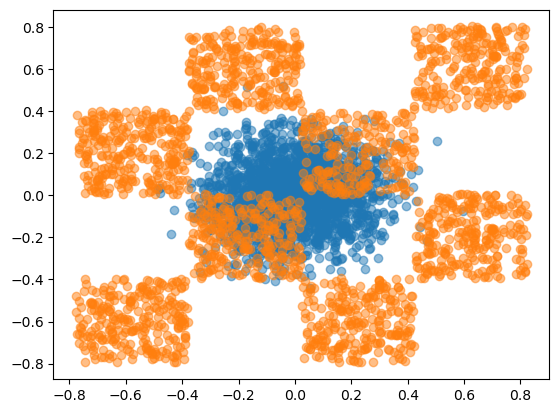

In [3]:
import torch
import matplotlib.pyplot as plt

def generate_checkerboard_sample(num_samples=10, field_size=0.4, num_fields=2, center=True):
    x = torch.rand(num_samples, 2) * field_size
    offset = torch.randint(0, num_fields, (num_samples, 2)) * field_size * 2
    diagonal_shift = torch.randint(0, num_fields, (num_samples, 1)) * field_size
    x += offset + diagonal_shift

    if center:
        x -= torch.mean(x, dim=0)

    return x

def generate_x0_sample(num_samples = 2000, base_distribution_std=0.15):
    return torch.randn(num_samples, 2) * base_distribution_std
    
base_distribution_std = 0.15
num_samples = 2000
x = generate_x0_sample(num_samples, base_distribution_std)
y = generate_checkerboard_sample(num_samples=num_samples)

# show points
plt.scatter(x[:, 0], x[:, 1], alpha=0.5, label='base distribution')
plt.scatter(y[:, 0], y[:, 1], alpha=0.5, label='checkerboard distribution')
plt.show()

In [5]:
# define a model
from torchvision.ops import MLP
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# input = spacial 1 + spacial 2 + time
model = MLP(in_channels=2 + 1, hidden_channels=[512, 512, 512, 512, 2], activation_layer=torch.nn.SiLU)
model.to(device)

# define a loss function
criterion = torch.nn.MSELoss(reduction="none")

# define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# train the model:
num_epochs = 5000  # use fewer epochs if it takes too long
batch_size = 4096
losses = []
for epoch in tqdm(range(num_epochs)):
    x0 = generate_x0_sample(num_samples=batch_size)
    x1 = generate_checkerboard_sample(num_samples=batch_size)
    # TODO: implement the training loop
    
    # 1. reset optimizer gradient
    optimizer.zero_grad()

    # 2. Calculate model prediction
    # here, t is uniformly sampled from [0,1] according to the expected value in eq. 1
    t = torch.rand(size=(batch_size,1))
    psi_t = (1-t)*x0 + t*x1
    psi = torch.hstack([psi_t, t])
    v = model(psi)
    
    # 3. calculate loss
    
    loss = torch.mean(criterion(v, (x1-x0)))
    losses.append(loss.detach().numpy())

    # 4. backpropagate loss
    loss.backward()

    # 5. Make optimizer step
    optimizer.step()
    

100%|███████████████████████████████████████████████████████████████████████████████| 5000/5000 [33:40<00:00,  2.47it/s]


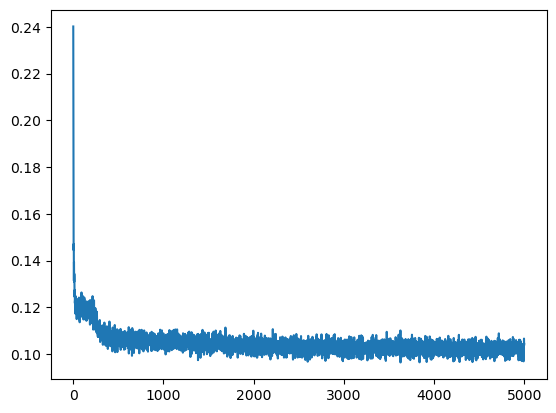

In [6]:
plt.plot(losses)

In [20]:
# TODO: run inference with the trained model. 
# Visualize the trajectory of the samples and the final samples at t=1.

# number of points
N = 2**15
# number of time steps
T = 100
x0 = generate_x0_sample(N)
x = torch.zeros(size=(T, N, 2))
x[0] = x0
dt = 1/T

for i, t in tqdm(enumerate(torch.linspace(dt,1,T-1))):
    # same time for all samples
    psi = torch.hstack([x[i], t*torch.ones([N,1])])
    v_t = model(psi)
    
    # 1st order Euler integration
    x[i+1] = x[i] + dt*v_t
    



0it [00:03, ?it/s]


KeyboardInterrupt: 

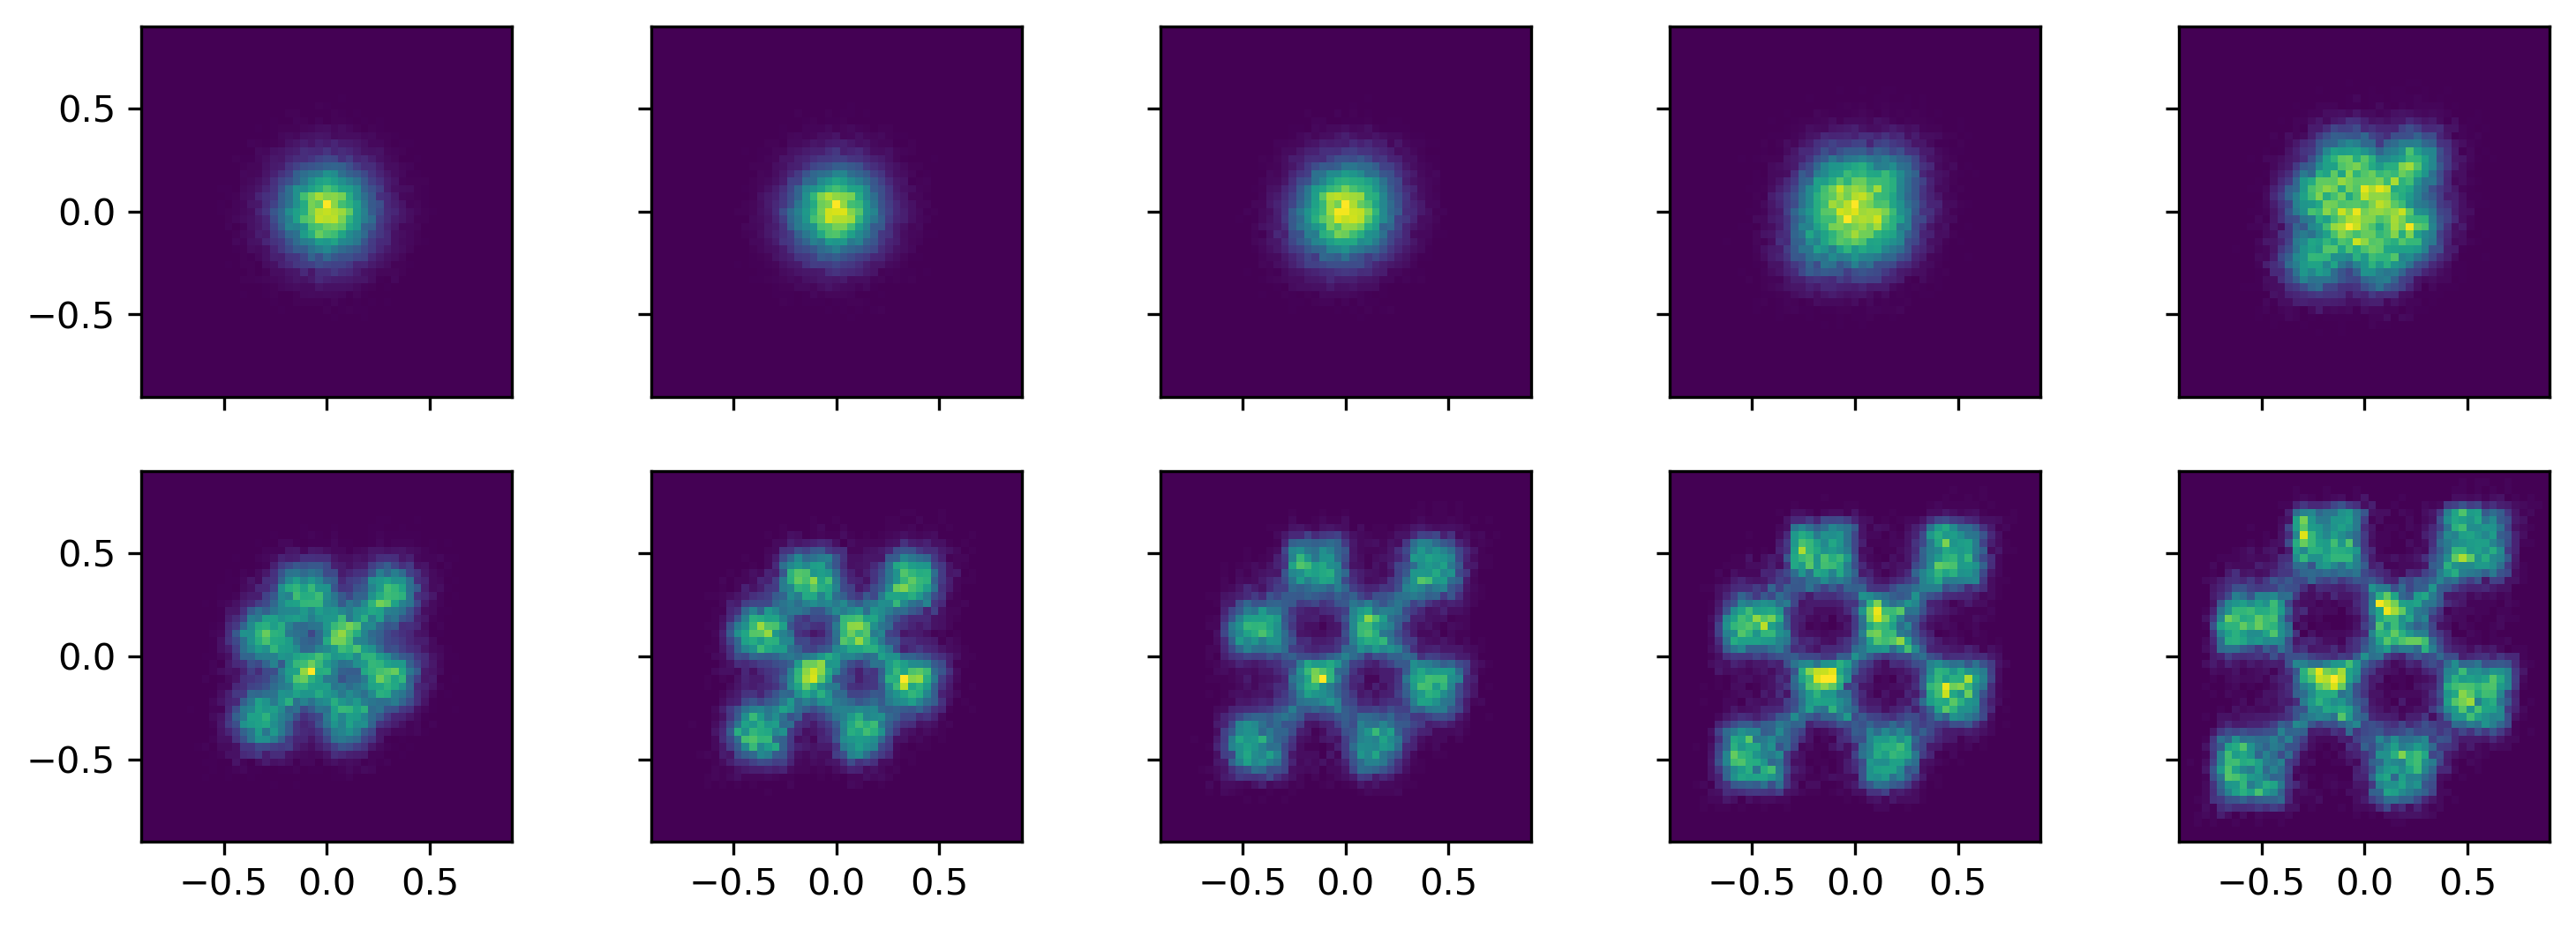

In [19]:
plt.rcParams["figure.dpi"] = 300
fig, axes = plt.subplots(2,5, figsize=(12,4), sharex=True, sharey=True)
axes = axes.flatten()
for i in range(0,100,10):
    # axes[i//10].scatter(*x[i].detach().numpy().T, s=1)
    #axes[i//10].scatter(*generate_checkerboard_sample(N).T, s=2)
    _x, _y = x[i].T
    _x, _y = torch.flatten(_x).detach().numpy(), torch.flatten(_y).detach().numpy()
    
    # histogram
    axes[i//10].hist2d(_x, _y, bins= np.linspace(-0.9, 0.9, 50))
    axes[i//10].set_aspect(1)


(b)

At $t=0$, the optimal velocity should in general try to displace samples from those squares that are empty according to $x_1$. Thus, we should see a checkerboard of sinks and sources. Since the distribution of $x_0$ has a smaller variance than the checkerboard pattern, should also see a halo of outward-pointing velocity vectors that will widen the distribution of samples. In general, we expect linear trajectories since that is what we specified in the loss function.

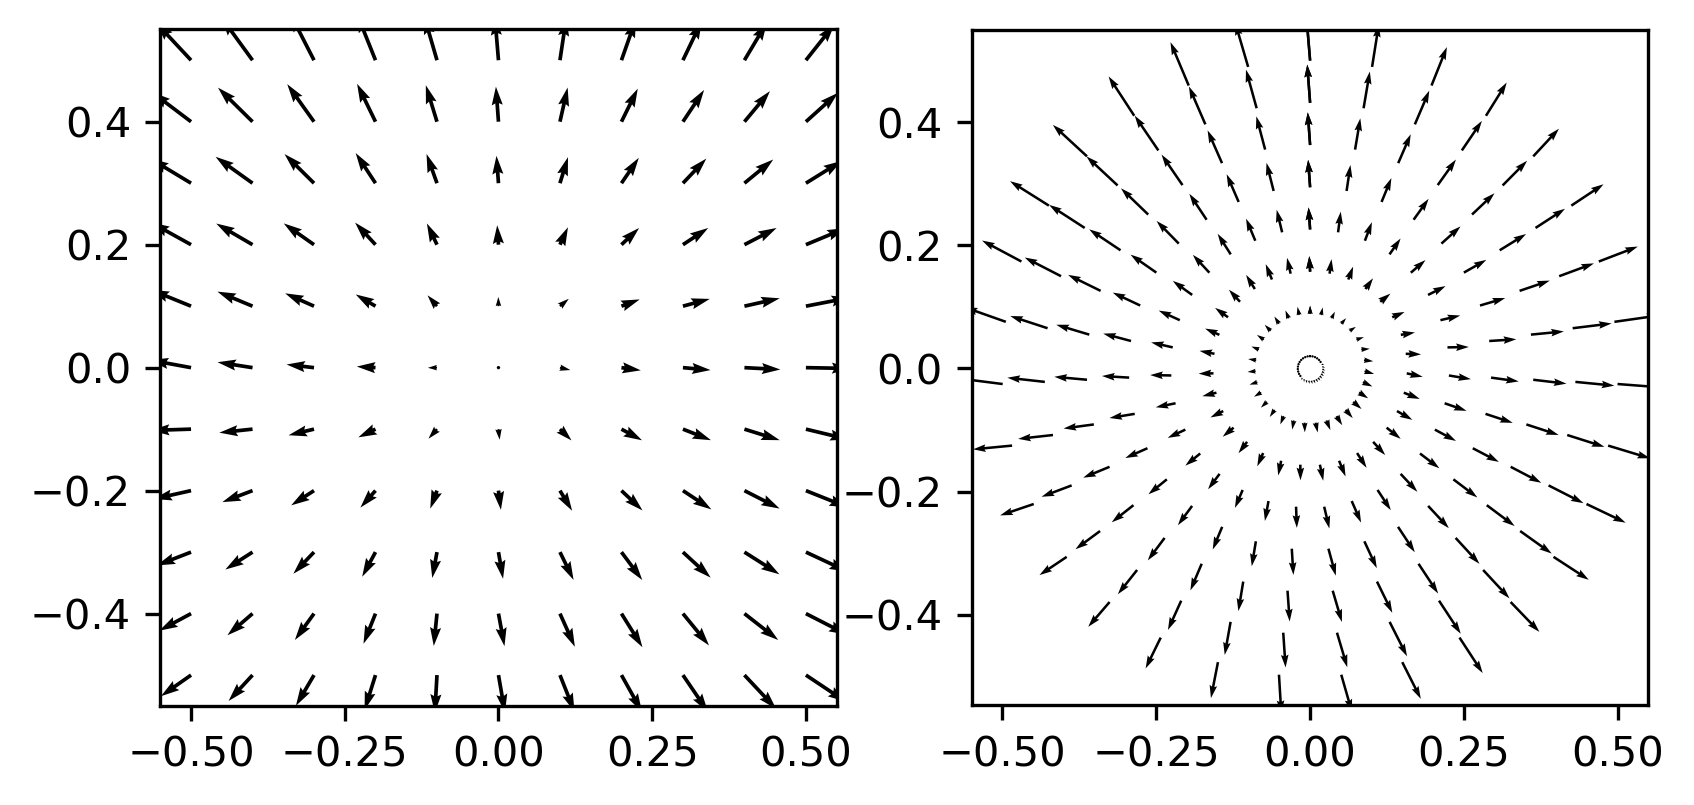

In [72]:

# 1. create meshgrid of [-0.5, 0.5]^2
interval = torch.linspace(-0.5, 0.5, 11)
arr = torch.stack(torch.meshgrid(interval, interval, indexing="ij"))

# 1a. create radial grid in [0, 2pi] x [0, 0.5]
phi = torch.linspace(0, 2*np.pi, 32).unsqueeze(0)
rho = torch.linspace(0.02,0.5, 8).unsqueeze(1)
arr2 = torch.stack([rho*torch.sin(phi),rho*torch.cos(phi)])

# 2. add constant time parameter
X = torch.cat([arr, 0*torch.ones((1,11,11))], dim=0)
X2 = torch.cat([arr2, 0*torch.ones((1,8,32))], dim=0)

X = torch.movedim(X, 0, 2)
X2 = torch.movedim(X2, 0, 2)

# 3. evaluate model
v = -model(X).detach().numpy()
v2 = -model(X2).detach().numpy()

# 4. visualize
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.quiver(*arr.detach().numpy(), v[:,:,0], v[:,:,1])
ax1.set_aspect(1)
ax2.quiver(*arr2.detach().numpy(), v2[:,:,0], v2[:,:,1])
ax2.set_aspect(1)

Indeed, the checkerboard pattern is already at visible at $t=0$, as indicated by the anisotropy of the vector field evaluated on the radial plot on the right, namely we see a misalignmend between adjacent arrow heads and tails in the second and fourth quadrant of the plot. From both plots it is apparent that the velocity field at $t=0$ predominantly expands the sample space.

(c)

At $t=0$, the velocity field is biased to move bulk mass away from the origin -- which would be ideal if our target distribution were similar to a torus. Because of this, some samples will take detours from the ideal linear path. This can be mitigated using minibatch optimal transport, which eliminates the averaging over many samples and thus debiases the velocity field.

## 3 Adversarial attacks and AI safety

In [73]:
'''
Logistric regression in pytorch (needed for backpropagation)
taken from https://github.com/saprmarks/geometry-of-truth/blob/main/probes.py
'''

class LRProbe(torch.nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d_in, 1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

    def pred(self, x):
        return self(x).round()
    
    def from_data(acts, labels, lr=0.001, weight_decay=0.1, epochs=1000, device='cpu'):
        acts, labels = acts.to(device), labels.to(device)
        probe = LRProbe(acts.shape[-1]).to(device)
        
        opt = torch.optim.AdamW(probe.parameters(), lr=lr, weight_decay=weight_decay)
        for _ in range(epochs):
            opt.zero_grad()
            loss = torch.nn.BCELoss()(probe(acts), labels)
            loss.backward()
            opt.step()
        
        return probe

    def __str__():
        return "LRProbe"

    @property
    def direction(self):
        return self.net[0].weight.data[0]

In [75]:
# We import the DataManager class as a helper function to load the activation vectors for us.
from lie_detection_utils import DataManager
from sklearn.metrics import accuracy_score

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

In [76]:
# train a model on the cities dataset
dataset_name = "cities"

dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
train_acts, train_labels = dm.get('train')
test_acts, test_labels = dm.get('val')

print("train_acts.shape", train_acts.shape)
print("test_acts.shape", test_acts.shape)

train_acts.shape torch.Size([1196, 4096])
test_acts.shape torch.Size([300, 4096])


In [77]:
# TODO: train a logistic regression probe on the train_acts and train_labels
# .from_data() implicitly trains the probe.
probe = LRProbe.from_data(train_acts, train_labels)


We choose the MSE here since evaluating the probe returns a continuous scalar. We could also use BCE but due to the lack of stochasticity (i.e. single-sample training) the loss gradient would almost definitely be zero, yielding no optimization.

In [266]:
# TODO: optimize a perturbation on a single sample which is a lie
sample = test_acts[test_labels.argmin()]
criterion = torch.nn.MSELoss()
perturbation = torch.randn(4096, requires_grad=True)
optimizer = torch.optim.SGD([perturbation], lr = 1e-3)

for _ in range(2000):
    optimizer.zero_grad()
    loss = criterion(probe(sample+perturbation), torch.tensor(1.0))
    loss.backward()
    optimizer.step()
    if _ % 200 == 0:
        print(loss)

tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)


In [269]:
# TODO: check whether this perturbation works on other samples too
lies = test_acts[test_labels == 0]
100 - 100*criterion(probe(lies+perturbation), torch.ones(lies.size()[0]))

tensor(98.2576, grad_fn=<RsubBackward1>)

In [273]:
torch.mean(torch.abs(perturbation))

tensor(0.8109, grad_fn=<MeanBackward0>)

The perturbation works as it tricks the lie detector to classify lies as truth in 98%+ of cases, but the average perturbation per dimension is high at 0.8

In [274]:
# TODO: add the constraint that the perturbation should be small
# TODO: optimize a perturbation on a single sample which is a lie
sample = test_acts[test_labels.argmin()]
criterion = torch.nn.MSELoss()
perturbation = torch.randn(4096)
perturbation = torch.tensor(perturbation, requires_grad=True)
optimizer = torch.optim.SGD([perturbation], lr = 1e-3)
loss = 1000
i = 0
for i in range(2000):
    optimizer.zero_grad()
    loss = criterion(probe(sample+perturbation), torch.tensor(1.0)) +  100*torch.norm(perturbation)
    loss.backward()
    optimizer.step()
    if i % 200 == 0:
        print(loss)
     

# TODO: check whether this perturbation works on other samples too
lies = test_acts[test_labels == 0]
100 - 100*criterion(probe.pred(lies+perturbation), torch.ones(lies.size()[0]))

/tmp/ipykernel_25943/436699319.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbation = torch.tensor(perturbation, requires_grad=True)


tensor(6325.5054, grad_fn=<AddBackward0>)
tensor(4325.5039, grad_fn=<AddBackward0>)
tensor(2325.5037, grad_fn=<AddBackward0>)
tensor(325.5030, grad_fn=<AddBackward0>)
tensor(5.5004, grad_fn=<AddBackward0>)
tensor(5.4984, grad_fn=<AddBackward0>)
tensor(5.4968, grad_fn=<AddBackward0>)
tensor(5.4955, grad_fn=<AddBackward0>)
tensor(5.4946, grad_fn=<AddBackward0>)
tensor(5.4940, grad_fn=<AddBackward0>)


tensor(0., grad_fn=<RsubBackward1>)

In [275]:
torch.mean(torch.norm(perturbation))

tensor(0.0449, grad_fn=<MeanBackward0>)

By enforcing the perturbation to be small (~1/20 its previous magnitude), the optimizer cannot find a perturbation that deceives the probe. There are no samples among the lies that are classified as truth. 
The linear represenation hypothesis states that some dimensions in latent space correspond to human-interpretable concepts. In our case, the latent space is the 4096-dimensional embedding of the city dataset tokens and our human-intepretable concept is that of truth and falsehood. Since we can find perturbations along the latent space that successfully manipulate the classification into truth and falsehood suggests that this hypothesis has some merit. For instance, we could try to measure falsehood along the 1d subspace spanned by our perturbation.